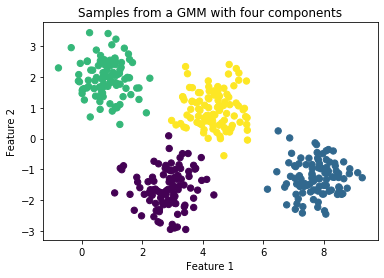

In [577]:
import numpy as np
import sklearn
from sklearn import mixture
from matplotlib import pyplot as plt
import scipy.stats as sp
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from sklearn.datasets.samples_generator import make_blobs
from matplotlib.ticker import FixedLocator, LinearLocator, FormatStrFormatter
from matplotlib import cm
import pandas as pd
from sklearn.metrics import silhouette_score
import scipy
from sklearn.cluster import KMeans
import pymc3 as pm
from theano import tensor as tt
import theano
eps = 1e-16


# Generate some data
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] 


kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Samples from a GMM with four components')
plt.show()

In [578]:
# Peform the kernel density estimate
x = X[:,0]
y = X[:,1]
xmin = np.min(x)
xmax = np.max(x)
ymin = np.min(y)
ymax = np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = sp.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

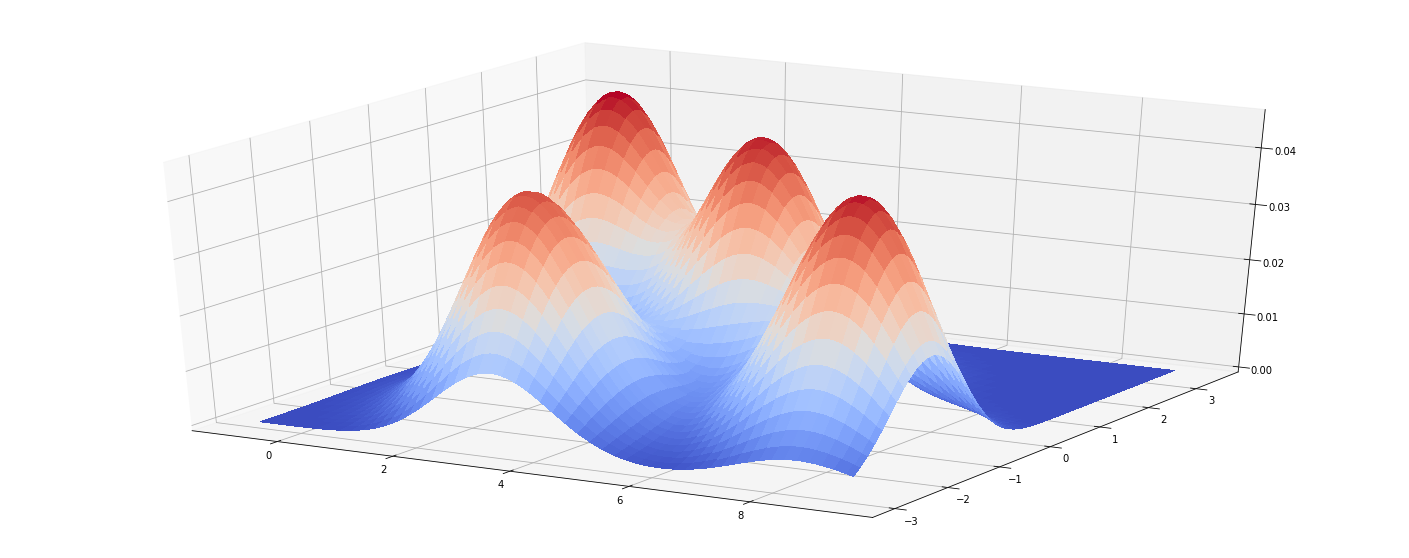

In [579]:
# Plot the surface.
fig = plt.figure(figsize=(25,10))
ax = fig.gca(projection='3d')

surf = ax.plot_surface(xx, yy, f, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

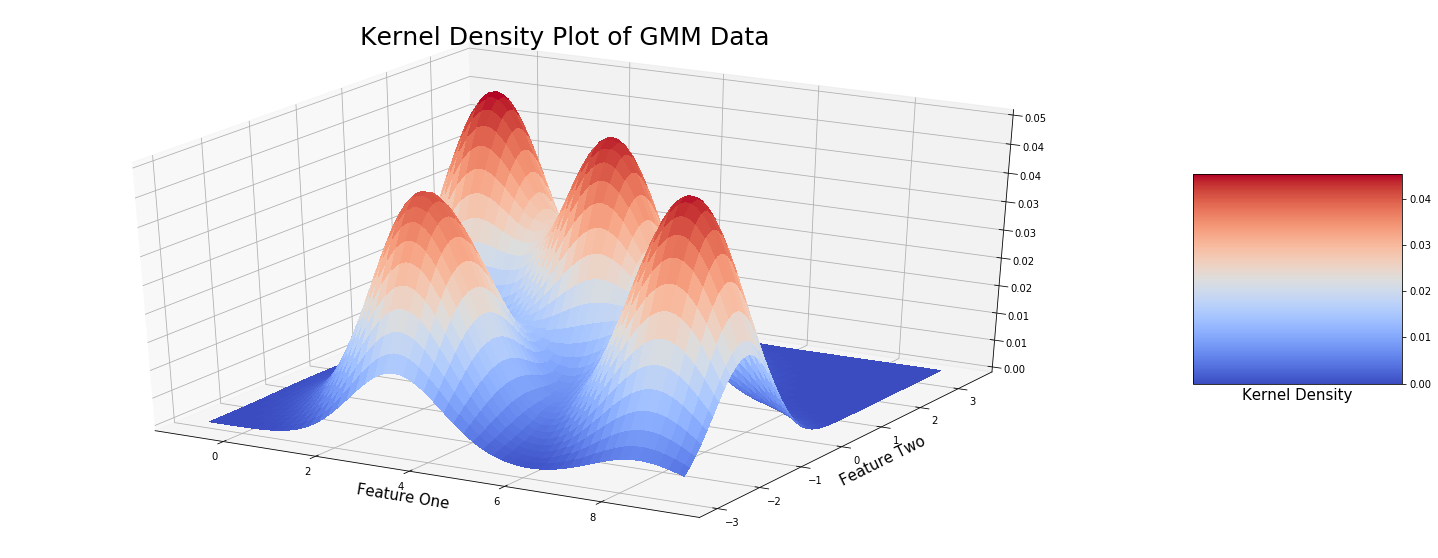

In [580]:
# Plot the surface.
fig = plt.figure(figsize=(25,10))
ax = fig.gca(projection='3d')

surf = ax.plot_surface(xx, yy, f, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
mate = fig.colorbar(surf, shrink=0.5, aspect=1)
mate.ax.set_xlabel('Kernel Density',fontsize=15)
plt.xlabel('Feature One',fontsize=15)
plt.ylabel('Feature Two',fontsize=15)
plt.title('Kernel Density Plot of GMM Data',fontsize=25)

plt.show()

In [581]:
def genCov(dim):
    a = 2
    A = np.matrix([np.random.randn(dim) + np.random.randn(1)*a for i in range(dim)])
    A = A*np.transpose(A)
    D_half = np.diag(np.diag(A)**(-0.5))
    C = D_half*A*D_half
    sigma = np.diag(np.random.uniform(low=0,high=5,size=(dim)))
    return np.dot(np.dot(sigma,C),sigma)

In [582]:
#Number of features in our GMM
dim=20
N=10000

#Number of clusters
n_clusters = np.random.choice(range(5,10))

#Sample random mixing proportions
mix_prop = np.random.dirichlet([1 for x in range(n_clusters)])

#Initialise random covariance matrices
covs = [genCov(dim) for x in range(n_clusters)]

#Initialise random mean vectors
means = [np.random.uniform(low=1,high=20,size=dim) for x in range(n_clusters)]

#Sample cluster assignments
gAssign = np.random.multinomial(10000, mix_prop)
assignments = np.repeat(range(n_clusters),gAssign)

#Generate Data
mix = np.vstack([sp.multivariate_normal.rvs(mean=m,cov=c,size=g) for m,c,g in zip(means,covs,gAssign)])

In [583]:
# Peform the kernel density estimate
x = mix[:,0]
y = mix[:,1]
xmin = np.min(x)
xmax = np.max(x)
ymin = np.min(y)
ymax = np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = sp.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

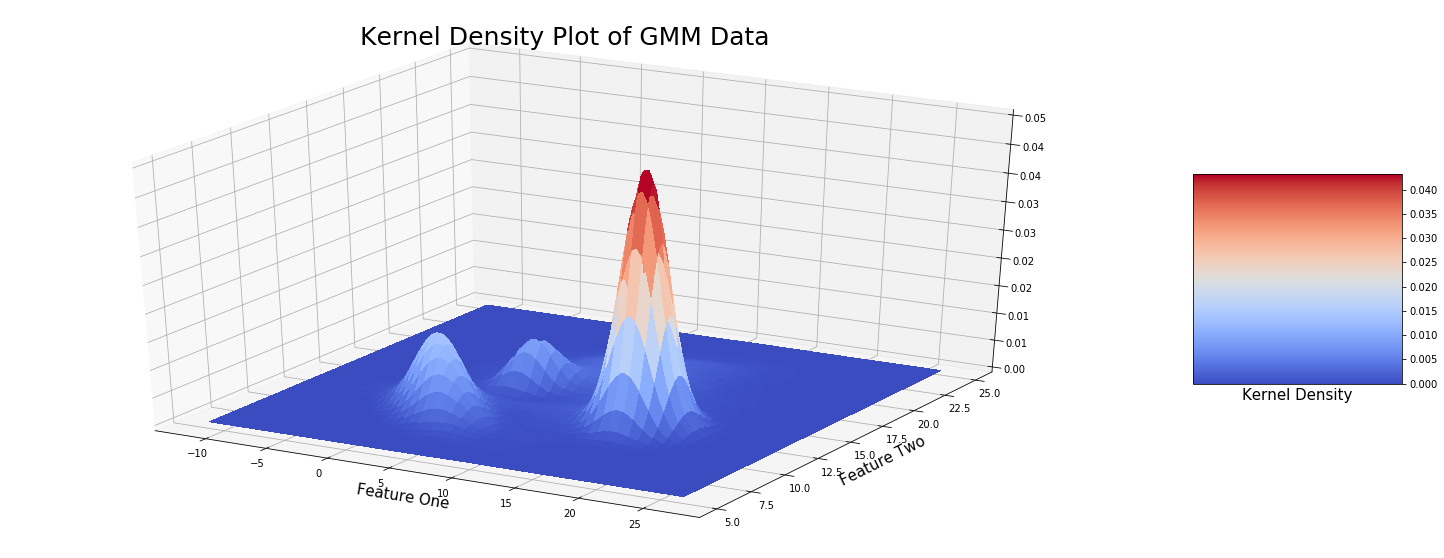

In [584]:
# Plot the surface.
fig = plt.figure(figsize=(25,10))
ax = fig.gca(projection='3d')

surf = ax.plot_surface(xx, yy, f, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
mate = fig.colorbar(surf, shrink=0.5, aspect=1)
mate.ax.set_xlabel('Kernel Density',fontsize=15)
plt.xlabel('Feature One',fontsize=15)
plt.ylabel('Feature Two',fontsize=15)
plt.title('Kernel Density Plot of GMM Data',fontsize=25)

plt.show()

In [585]:
DPGMM = mixture.BayesianGaussianMixture(n_components=15, 
                                                max_iter=100000000,
                                                n_init=10,
                                                tol=1e-5, 
                                                init_params='kmeans', 
                                                weight_concentration_prior_type='dirichlet_process',
                                                weight_concentration_prior=1/10)
DPGMM.fit(mix)

BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
                        degrees_of_freedom_prior=None, init_params='kmeans',
                        max_iter=100000000, mean_precision_prior=None,
                        mean_prior=None, n_components=15, n_init=10,
                        random_state=None, reg_covar=1e-06, tol=1e-05,
                        verbose=0, verbose_interval=10, warm_start=False,
                        weight_concentration_prior=0.1,
                        weight_concentration_prior_type='dirichlet_process')

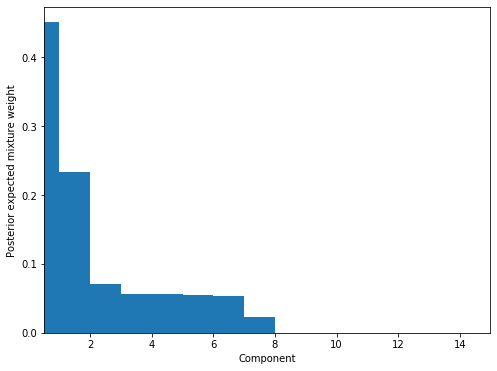

In [586]:
fig, ax = plt.subplots(figsize=(8, 6))

plot_w = np.arange(15) + 1

ax.bar(plot_w - 0.5, np.sort(DPGMM.weights_)[::-1], width=1., lw=0);

ax.set_xlim(0.5, 15);
ax.set_xlabel('Component');

ax.set_ylabel('Posterior expected mixture weight');

In [587]:
n_to_select = 8
w = (-DPGMM.weights_).argsort()[:n_to_select]
mat = []
for ind2 in w:
    row = []
    for ind1 in range(len(means)):
        p1 = sp.multivariate_normal.pdf(mix,mean=means[ind1],cov=covs[ind1]) + eps
        p2 = sp.multivariate_normal.pdf(mix,mean=DPGMM.means_[ind2],cov=DPGMM.covariances_[ind2]) + eps
        row.append(sp.entropy(p1 + eps,p2 + eps))
    mat.append(row)
print(pd.DataFrame(mat))

           0          1          2          3          4          5  \
0  27.360867  25.828138  26.183362  26.038610   0.159885  26.023427   
1  18.468689  16.935968  17.291186  17.146432  15.058974  17.131249   
2  15.622676  14.089957  14.445172  14.300418  12.212961  14.285236   
3  16.950549  15.417830   0.352265  15.628291  13.540834  15.613109   
4  22.617134  21.084415  21.439631   0.452674  19.207419  21.279694   
5  14.765195   0.298968  13.587691  13.442937  11.355480  13.427755   
6  17.263958  15.731239  16.086454  15.941700  13.854243   0.383633   
7   0.391462  16.465035  16.820250  16.675496  14.588038  16.660313   

           6          7  
0  24.641451  25.658286  
1   0.227241  16.766112  
2  12.903262   0.289566  
3  14.231135  15.247972  
4  19.897721  20.914557  
5  12.045781  13.062618  
6  14.544544  15.561381  
7  15.278340  16.295177  


In [588]:
w

array([9, 7, 4, 8, 6, 2, 3, 5])

In [589]:
mat = []
for ind2 in w:
    p1 = sp.multivariate_normal.pdf(mix,mean=DPGMM.means_[ind2],cov=DPGMM.covariances_[ind2]) + eps
    mat.append(p1)
clusts = pd.DataFrame(mat).T.idxmax(axis=1)

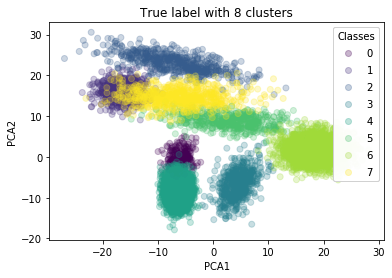

In [590]:
from sklearn.decomposition import PCA
pca= PCA(n_components=2)
X = pca.fit_transform(mix)
fig, ax = plt.subplots()


scatter = ax.scatter(X[:, 0], X[:, 1], c=assignments, cmap=plt.cm.viridis, alpha=.25);
plt.title("True label with %s clusters" %len(np.unique(assignments)));
plt.xlabel('PCA1')
plt.ylabel('PCA2')

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)

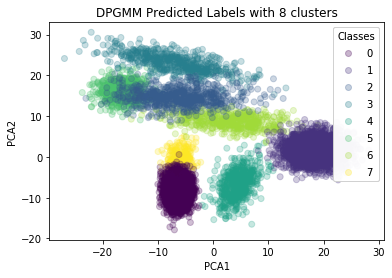

In [591]:
fig, ax = plt.subplots()


scatter = ax.scatter(X[:, 0], X[:, 1], c=clusts, cmap=plt.cm.viridis, alpha=.25);
plt.title("DPGMM Predicted Labels with %s clusters" %len(np.unique(clusts)));
plt.xlabel('PCA1')
plt.ylabel('PCA2')

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)

Text(0.5, 0, 'Average Silhouette Score')

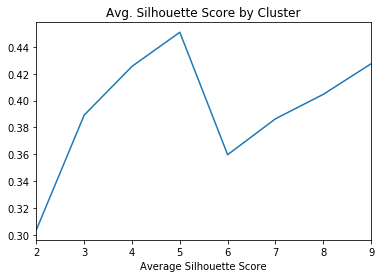

In [592]:
range_n_clusters = [2, 3, 4, 5, 6,7,8,9]
silscore = []
for n_clusters in range_n_clusters:
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(mix)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(mix, cluster_labels)
    silscore.append(silhouette_avg)
pd.Series(silscore,index=range_n_clusters).plot()
plt.title('Avg. Silhouette Score by Cluster')
plt.xlabel('N. Clusters')
plt.xlabel('Average Silhouette Score')

In [593]:
n_clust = 6
clusterer = KMeans(n_clusters=n_clust, random_state=10)
cluster_labels = clusterer.fit_predict(mix)
mat = []
for c in range(n_clust):
    row = []
    m_sub = mix[cluster_labels == c].mean(axis=0)
    m_cov = np.cov(mix[cluster_labels == c].transpose())
    for ind1 in range(len(means)):
        p1 = sp.multivariate_normal.pdf(mix,mean=means[ind1],cov=covs[ind1]) + eps
        p2 = sp.multivariate_normal.pdf(mix,mean=m_sub,cov=m_cov) + eps
        row.append(sp.entropy(p1,p2))
    mat.append(row)
print(pd.DataFrame(mat))

           0          1          2          3          4          5  \
0  20.136724  18.604016  18.959223  18.814467  16.727009  18.799285   
1   5.880713  10.990461  11.345666   0.868539   9.113453  11.185728   
2  31.861345  30.328632  30.683843  30.539087   0.782438  30.523905   
3   6.120203   3.916545   3.744420   4.797945   2.710488   4.782763   
4  32.038662  30.505949  30.861160  30.716404   0.666286  30.701222   
5   8.928838   7.396131   7.751337   7.606580   5.519123   2.559872   

           6          7  
0   0.116508  18.434152  
1   9.803756  10.820596  
2  29.141932  30.158770  
3   3.400791   4.417631  
4  29.319249  30.336088  
5   6.209426   1.333473  


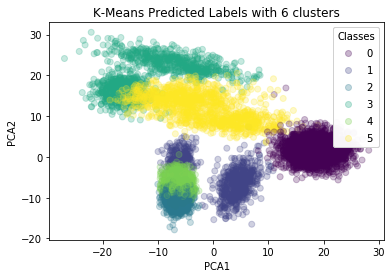

In [594]:
fig, ax = plt.subplots()
scatter = ax.scatter(X[:, 0], X[:, 1], c=cluster_labels, cmap=plt.cm.viridis, alpha=.25);
plt.title("K-Means Predicted Labels with %s clusters" %len(np.unique(cluster_labels)));
plt.xlabel('PCA1')
plt.ylabel('PCA2')

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)